In [53]:
import sys; sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

LOADING DATA FROM KAGGLE

In [54]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [55]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

melanoma-skin-cancer-dataset-of-10000-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [56]:
import zipfile
zip_ref = zipfile.ZipFile('/content/melanoma-skin-cancer-dataset-of-10000-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [57]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [58]:
train_path = '/content/melanoma_cancer_dataset/train'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

Found 9605 files belonging to 2 classes.


In [59]:
test_path = '/content/melanoma_cancer_dataset/test'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 1000 files belonging to 2 classes.


DATASET SPLITTING

In [60]:
DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

240 61


DATASET VISUALIZATION

In [61]:
import matplotlib.pyplot as plt

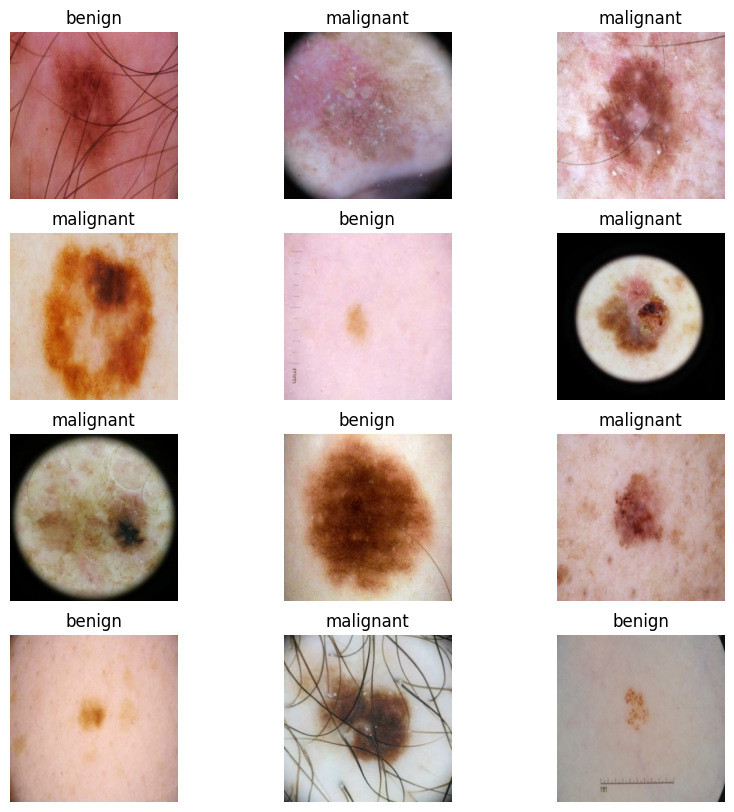

In [62]:
class_names = ds.class_names
plt.figure(figsize= (10,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis('off')

MODEL BUILDING

In [63]:
from keras.layers import RandomFlip, RandomRotation

In [64]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [65]:
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label
train, val, test = train.map(Normalizer), val.map(Normalizer), test.map(Normalizer)

In [66]:
model = Sequential([
    Augmentation,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32, 256, 256, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=2, activation="Softmax"),
])
model.build (input_shape=(32, 256, 256, 3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 32)         

In [67]:
model.compile(
    optimizer= 'adam',
    loss=  'sparse_categorical_crossentropy',
    metrics = ['accuracy',]
)

In [72]:
from keras.callbacks import EarlyStopping

In [73]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True,
)

MODEL TRAINING

In [74]:
history = model.fit(train, batch_size= 32, epochs=25, verbose=1, validation_data=val, callbacks=[early_stopping])

Epoch 1/25
240/240 [==============================] - 23s 94ms/step - loss: 0.2581 - accuracy: 0.8888 - val_loss: 0.2752 - val_accuracy: 0.8826
Epoch 2/25
240/240 [==============================] - 23s 95ms/step - loss: 0.2502 - accuracy: 0.8974 - val_loss: 0.2346 - val_accuracy: 0.9029
Epoch 3/25
240/240 [==============================] - 23s 94ms/step - loss: 0.2556 - accuracy: 0.8926 - val_loss: 0.2784 - val_accuracy: 0.8904
Epoch 4/25
240/240 [==============================] - 24s 97ms/step - loss: 0.2523 - accuracy: 0.8965 - val_loss: 0.2455 - val_accuracy: 0.8899
Epoch 5/25
240/240 [==============================] - 23s 93ms/step - loss: 0.2450 - accuracy: 0.8999 - val_loss: 0.2579 - val_accuracy: 0.8899


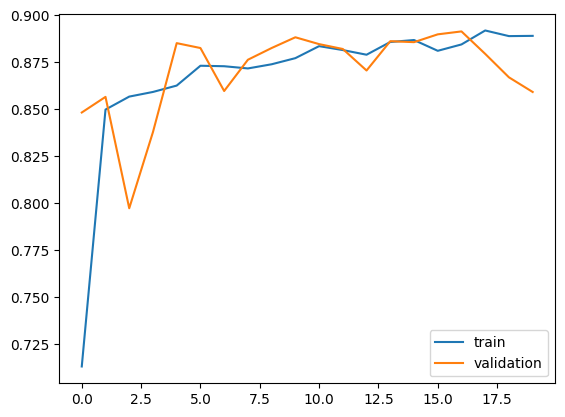

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

MODEL EVALUATION

In [70]:
loss, accuracy = model.evaluate(test); print(loss, accuracy)

32/32 [==============================] - 2s 46ms/step - loss: 0.2735 - accuracy: 0.8890
0.2734646797180176 0.8889999985694885


Actual Label:  malignant
1/1 [==============================] - 0s 103ms/step
Predicted Label:  malignant


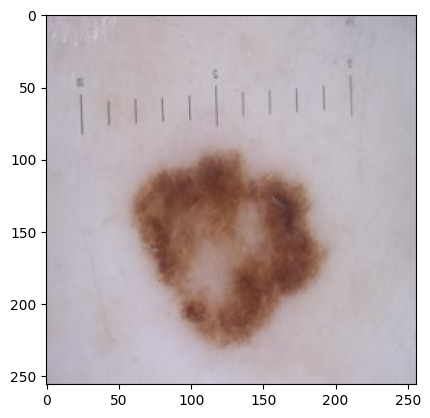

In [71]:
for images, label in test.take(1):
  img = (images[0]*255).numpy().astype('uint8')
  plt.imshow(img)
  print('Actual Label: ', class_names[label[0].numpy()])
  pred = model.predict(images)
  print('Predicted Label: ', class_names[np.argmax(pred[0])])